Q3. Machine learning on Image Dataset

3.3 Data Preprocessing

In [1]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt


In [2]:
# Load all the images from the folder

image_folder = "/content/drive/MyDrive/ImageDataset_Q3"
image_files = glob(os.path.join(image_folder, "*.png"))

processed_images = []
original_images = []

#Preprocessing loop
for file in image_files:
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  original_images.append(img)

  img_resized = cv2.resize(img, (256,256)) #standard resize
  img_norm = img_resized / 255.0           # normalise (0-1)

  processed_images.append(img_norm)

#convert processed images to numpy array
processed_images = np.array(processed_images)

print("Total images loaded:", len(processed_images))
print("Image dataset shape:", processed_images.shape)
print("Original images stored as list length:", len(original_images))

Total images loaded: 10
Image dataset shape: (10, 256, 256)
Original images stored as list length: 10


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

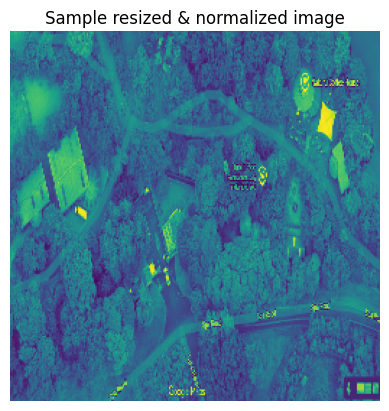

In [3]:
#Shw sample processed image
plt.imshow(processed_images[0])
plt.title("Sample resized & normalized image")
plt.axis('off')

3.4 Labelling the dataset

In [4]:
import os
from pathlib import Path
import csv
from  glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

#Image path
image_folder = Path("/content/drive/MyDrive/ImageDataset_Q3")
image_folder.mkdir(parents=True, exist_ok=True)

#collect image file names (png/jpg)
image_files = sorted([p for p in image_folder.glob("*.png")] + [p for p in image_folder.glob("*.jpg")])
print("Found images:", len(image_files))
for p in image_files:
  print("-", p.name)

Found images: 10
- CityCenter.png
- DCUCollegeCampus.png
- DublinAirport.png
- DublinPort.png
- DublinZoo.png
- Farmland.png
- HowthCosta.png
- RoyalCanal.png
- Santry.png
- WicklowMountains.png


In [5]:
#Create labels via dict
labels_dict = {
    "DCUCollegeCampus.png": "campus",
    "DublinAirport.png": "airport",
    "DublinPort.png": "port",
    "DublinZoo.png" : "zoo",
    "HowthCoast.png" : "coast",
    "WicklowMountains.png" : "mountain",
    "CityCenter.png" : "city_center",
    "Farmland.png" : "farmland",
    "RoyalCanal.png": "water",
    "Santry.png" : "residential"
}

#Build CSV rows
rows = [("filename" , "label")]
for p in image_files:
  lab = labels_dict.get(p.name, "unknown")
  rows.append((p.name, lab))

#save CSV
csv_path = image_folder / "labels.csv"
with open(csv_path, "w", newline="") as f:
  writer = csv.writer(f)
  writer.writerows(rows)

print("saved labels.csv to:", csv_path)

saved labels.csv to: /content/drive/MyDrive/ImageDataset_Q3/labels.csv


In [6]:
# load and validate labels
import pandas as pd
csv_path = image_folder / "labels.csv"
df = pd.read_csv(csv_path)
print(df)
print("\nLabel counts:")
print(df['label'].value_counts())


               filename        label
0        CityCenter.png  city_center
1  DCUCollegeCampus.png       campus
2     DublinAirport.png      airport
3        DublinPort.png         port
4         DublinZoo.png          zoo
5          Farmland.png     farmland
6        HowthCosta.png      unknown
7        RoyalCanal.png        water
8            Santry.png  residential
9  WicklowMountains.png     mountain

Label counts:
label
city_center    1
campus         1
airport        1
port           1
zoo            1
farmland       1
unknown        1
water          1
residential    1
mountain       1
Name: count, dtype: int64


In [7]:
#Visual Check: Plt of each image with its label
fig, axes = plt.subplots(len(image_files)//2+1,2, figsize=(10, 4*(len(image_files)//2 +1)))
axes = axes.flatten()

for i, p in enumerate(image_files):
  img = Image.open(p).convert("RGB")
  axes[i].imshow(img)
  lab = df.loc[df['filename'] == p.name, 'label'].values
  axes[i].set_title(f"{p.name} -> {lab[0] if len(lab) > 0 else 'NA'}")
  axes[i].axis('off')

#hide unused axes
for j in range(i+1, len(axes)):
  axes[j].axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

3.5 Split Dataset into train / test / Validation

In [8]:
# prepare array for splitting: X (images) & y (labels) array
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

#Load labels CSV
df = pd.read_csv(image_folder / "labels.csv")

# X processed images
X = np.array(processed_images)

#y numeric labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Classes:", label_encoder.classes_)

X shape: (10, 256, 256)
y shape: (10,)
Classes: ['airport' 'campus' 'city_center' 'farmland' 'mountain' 'port'
 'residential' 'unknown' 'water' 'zoo']


In [9]:
# Inspect labels to see distribution
import pandas as pd
df = pd.read_csv(image_folder / "labels.csv")
print(df)
print("\nLabel counts:")
print(df['label'].value_counts())


               filename        label
0        CityCenter.png  city_center
1  DCUCollegeCampus.png       campus
2     DublinAirport.png      airport
3        DublinPort.png         port
4         DublinZoo.png          zoo
5          Farmland.png     farmland
6        HowthCosta.png      unknown
7        RoyalCanal.png        water
8            Santry.png  residential
9  WicklowMountains.png     mountain

Label counts:
label
city_center    1
campus         1
airport        1
port           1
zoo            1
farmland       1
unknown        1
water          1
residential    1
mountain       1
Name: count, dtype: int64


In [10]:
#Manual split that ensures each class has at least one sample in the training set

import numpy as np
from sklearn.model_selection import train_test_split
import random

random.seed(42)
np.random.seed(42)

# Parameters
desired_train_frac = 0.7   # target fraction for training set (approx)
n_total = len(image_files)
desired_train = max(1, int(round(desired_train_frac * n_total)))

# Build mapping filename -> index
name_to_idx = {p.name: i for i, p in enumerate(image_files)}

# Group indices by class
class_groups = {}
for i, fname in enumerate(df['filename']):
    lab = df.loc[df['filename'] == fname, 'label'].values[0]
    class_groups.setdefault(lab, []).append(name_to_idx[fname])

print("Classes and their indices:")
for k, v in class_groups.items():
    print(k, v)

# Step 1: ensure at least one sample from each class goes to train
train_indices = []
for k, indices in class_groups.items():
    # pick one index (if multiple pick random one)
    pick = random.choice(indices)
    train_indices.append(pick)

# Step 2: if we still need more training images, fill randomly from remaining
remaining_indices = [i for i in range(n_total) if i not in train_indices]
num_needed = max(0, desired_train - len(train_indices))
if num_needed > 0:
    extra = random.sample(remaining_indices, min(num_needed, len(remaining_indices)))
    train_indices.extend(extra)

# Prepare remaining indices for val/test split
remaining_indices = [i for i in range(n_total) if i not in train_indices]

# If no remaining images, we will move one from train to validation (edge case)
if len(remaining_indices) == 0:
    # make last train image a validation
    moved = train_indices.pop()
    remaining_indices = [moved]

# Now split remaining into validation and test (approx 50/50 of remaining)
if len(remaining_indices) >= 2:
    val_idx, test_idx = train_test_split(remaining_indices, test_size=0.5, random_state=42)
else:
    # If only one remaining image, use it as validation and leave test empty
    val_idx = remaining_indices
    test_idx = []

# Build final arrays
X_train = X[train_indices]
y_train = y[train_indices]

X_val = X[val_idx] if len(val_idx) > 0 else np.empty((0,)+X.shape[1:])
y_val = y[val_idx] if len(val_idx) > 0 else np.array([])

X_test = X[test_idx] if len(test_idx) > 0 else np.empty((0,)+X.shape[1:])
y_test = y[test_idx] if len(test_idx) > 0 else np.array([])

# Show result summary
print("\nTrain indices:", train_indices)
print("Val indices:", val_idx)
print("Test indices:", test_idx)
print("\nTrain size:", X_train.shape, "Val size:", X_val.shape, "Test size:", X_test.shape)

# Show filenames in each split
print("\nTrain files:", [image_files[i].name for i in train_indices])
print("Val files:", [image_files[i].name for i in val_idx])
print("Test files:", [image_files[i].name for i in test_idx])


Classes and their indices:
city_center [0]
campus [1]
airport [2]
port [3]
zoo [4]
farmland [5]
unknown [6]
water [7]
residential [8]
mountain [9]

Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Val indices: [9]
Test indices: []

Train size: (9, 256, 256) Val size: (1, 256, 256) Test size: (0, 256, 256)

Train files: ['CityCenter.png', 'DCUCollegeCampus.png', 'DublinAirport.png', 'DublinPort.png', 'DublinZoo.png', 'Farmland.png', 'HowthCosta.png', 'RoyalCanal.png', 'Santry.png']
Val files: ['WicklowMountains.png']
Test files: []


3.6 Train a machine learning model K-mean clustering

In [11]:
#Imports and helper functions
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pathlib import Path
from PIL import Image

#save clustered outputs
out_folder = Path("/content/satellite_images/clustered_outputs")
out_folder.mkdir(parents=True, exist_ok=True)

def ensure_4d_images(arr):
    """
    Ensure image array is shape (N, H, W, 3).
    Accepts:
      - arr shape (N, H, W, 3)
      - arr shape (N, H, W)  -> will be expanded to 3 channels (grayscale->RGB)
    """
    arr = np.array(arr)
    if arr.ndim == 3:
        # Could be (N, H, W) or (H, W, 3) — attempt to detect
        if arr.shape[-1] == 3:
            # shape (H, W, 3) -> make (1, H, W, 3)
            arr = arr[np.newaxis, ...]
        else:
            # shape (N, H, W) -> expand to RGB
            arr = np.repeat(arr[..., np.newaxis], 3, axis=-1)
    if arr.ndim == 4 and arr.shape[-1] == 3:
        return arr
    raise ValueError("Unexpected array shape: " + str(arr.shape))

def image_to_pixels(img):
    """Convert H,W,3 array to (H*W, 3) float array"""
    h, w = img.shape[:2]
    pixels = img.reshape(-1, img.shape[2]).astype(float)
    return pixels, (h, w)


In [12]:
# KMeans per-image clustering function
def cluster_image_kmeans(img, k=4, random_state=42, scale_pixels=True):
    """
    img: H,W,3 array (0-1 float or 0-255)
    returns: cluster_map (H,W ints 0..k-1), colored_seg (H,W,3 uint8)
    """
    img_float = img.astype(float)

    # if scaled in 0–1, expand to 0–255
    if img_float.max() <= 1.1:
        img_float = img_float * 255.0

    pixels, (h, w) = image_to_pixels(img_float)

    if scale_pixels:
        mins = np.min(pixels, axis=0)
        ranges = np.ptp(pixels, axis=0) + 1e-9
        pixels_scaled = (pixels - mins) / ranges
    else:
        pixels_scaled = pixels

    km = KMeans(n_clusters=k, n_init=10, random_state=random_state)
    labels = km.fit_predict(pixels_scaled)
    cluster_map = labels.reshape(h, w)

    # For visualization: use cluster centers
    centers = km.cluster_centers_

    # unscale cluster centers back into original approx space
    if scale_pixels:
        centers_unscaled = (centers * ranges) + mins
    else:
        centers_unscaled = centers

    # Build colored segmentation
    colored = np.zeros((h*w, 3), dtype=np.uint8)
    for i in range(k):
        colored[labels == i] = np.clip(centers_unscaled[i], 0, 255).astype(np.uint8)

    colored_seg = colored.reshape(h, w, 3)

    return cluster_map, colored_seg


In [13]:
processed_images_4d = ensure_4d_images(processed_images)

k = 4    # choose number of clusters
random_state = 42

for idx, img in enumerate(processed_images_4d):
    cluster_map, colored_seg = cluster_image_kmeans(img, k=k, random_state=random_state)
    # fetch original image for display (if you stored it)
    orig = original_images[idx] if 'original_images' in globals() and len(original_images) > idx else (img * 255).astype(np.uint8)

    # Plot original, cluster map (colored by cluster center), and a cluster id map (label colors)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(orig); plt.title(f"Original ({image_files[idx].name})"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(colored_seg); plt.title(f"KMeans colored (k={k})"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(cluster_map, cmap='tab20'); plt.title("Cluster IDs"); plt.axis('off')
    plt.show()

    # Save the colored segmentation to disk
    save_path = out_folder / f"{image_files[idx].stem}_k{k}_seg.png"
    Image.fromarray(colored_seg).save(save_path)
    print("Saved segmented image to:", save_path)


Output hidden; open in https://colab.research.google.com to view.

3.7 Machine learning model (Simple CNN)

In [14]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)



In [15]:
# ensure images have 3 channels
def ensure_rgb(img):
    if img.ndim == 2:  # grayscale
        return np.stack([img, img, img], axis=-1)
    if img.ndim == 3 and img.shape[-1] == 1:
        return np.repeat(img, 3, axis=-1)
    return img  # already RGB

processed_images_fixed = np.array([ensure_rgb(img) for img in processed_images])

print("Fixed shape:", processed_images_fixed.shape)


Fixed shape: (10, 256, 256, 3)


In [16]:
# Use your corrected images (with channel dimension = 3)
X = processed_images_fixed   # shape: (10,256,256,3)

# Labels remain the same
y = label_encoder.transform(df['label'])


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
import random

random.seed(42)
np.random.seed(42)

# Parameters
desired_train_frac = 0.7
n_total = len(image_files)
desired_train = max(1, int(round(desired_train_frac * n_total)))

name_to_idx = {p.name: i for i, p in enumerate(image_files)}

class_groups = {}
for i, fname in enumerate(df['filename']):
    lab = df.loc[df['filename'] == fname, 'label'].values[0]
    class_groups.setdefault(lab, []).append(name_to_idx[fname])

train_indices = []
for k, indices in class_groups.items():
    pick = random.choice(indices)
    train_indices.append(pick)

remaining_indices = [i for i in range(n_total) if i not in train_indices]
num_needed = max(0, desired_train - len(train_indices))
if num_needed > 0:
    extra = random.sample(remaining_indices, min(num_needed, len(remaining_indices)))
    train_indices.extend(extra)

remaining_indices = [i for i in range(n_total) if i not in train_indices]

if len(remaining_indices) == 0:
    moved = train_indices.pop()
    remaining_indices = [moved]

if len(remaining_indices) >= 2:
    val_idx, test_idx = train_test_split(remaining_indices, test_size=0.5, random_state=42)
else:
    val_idx = remaining_indices
    test_idx = []

# FINAL arrays (correct shape now!)
X_train = X[train_indices]
y_train = y[train_indices]

X_val = X[val_idx] if len(val_idx) > 0 else np.empty((0,)+X.shape[1:])
y_val = y[val_idx] if len(val_idx) > 0 else np.array([])

X_test = X[test_idx] if len(test_idx) > 0 else np.empty((0,)+X.shape[1:])
y_test = y[test_idx] if len(test_idx) > 0 else np.array([])

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (9, 256, 256, 3)
Val shape: (1, 256, 256, 3)
Test shape: (0, 256, 256, 3)


In [18]:
#Prepare arrays and one-hot labels
def prepare_X(X):
    Xf = X.astype('float32')
    if Xf.max() > 1.1:
        Xf = Xf / 255.0
    return Xf

X_train_f = prepare_X(X_train)
X_val_f   = prepare_X(X_val) if X_val.size else np.empty((0,)+X_train.shape[1:])
X_test_f  = prepare_X(X_test) if X_test.size else np.empty((0,)+X_train.shape[1:])

num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat   = to_categorical(y_val, num_classes=num_classes) if y_val.size else np.empty((0,num_classes))
y_test_cat  = to_categorical(y_test, num_classes=num_classes) if y_test.size else np.empty((0,num_classes))

print("Prepared shapes:")
print("X_train:", X_train_f.shape, "y_train:", y_train_cat.shape)
print("X_val:", X_val_f.shape, "y_val:", y_val_cat.shape)
print("X_test:", X_test_f.shape, "y_test:", y_test_cat.shape)
print("Num classes:", num_classes)


Prepared shapes:
X_train: (9, 256, 256, 3) y_train: (9, 10)
X_val: (1, 256, 256, 3) y_val: (1, 10)
X_test: (0, 256, 256, 3) y_test: (0, 10)
Num classes: 10


In [19]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True,
    fill_mode='reflect'
)

batch_size = 4
train_generator = train_datagen.flow(X_train_f, y_train_cat, batch_size=batch_size, shuffle=True, seed=SEED)

# simple validation generator (no augmentation)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(X_val_f, y_val_cat, batch_size=max(1, len(X_val_f)))


In [20]:
# Smaller CNN using GlobalAveragePooling
input_shape = X_train_f.shape[1:]

def build_small_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # replace flatten with global average pooling
        layers.GlobalAveragePooling2D(),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_small_cnn(input_shape, num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,154 (399.04 KB)

 Trainable params: 102,154 (399.04 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Training: small CNN with callbacks (run this)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 30
# fewer steps to avoid exhaustion; still uses augmentation
steps_per_epoch = max(5, len(X_train_f) * 4)  # e.g., 9*4 = 36 steps

checkpoint_path = str(image_folder / "best_small_cnn.h5")
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(X_val_f, y_val_cat) if X_val_f.size else None,
    callbacks=callbacks,
    verbose=2
)

print("Training finished. Best model saved to:", checkpoint_path)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 2.22885, saving model to /content/drive/MyDrive/ImageDataset_Q3/best_small_cnn.h5


36/36 - 6s - 176ms/step - accuracy: 0.0000e+00 - loss: 2.3644 - val_accuracy: 1.0000 - val_loss: 2.2289
Epoch 2/30

Epoch 2: val_loss did not improve from 2.22885
36/36 - 1s - 41ms/step - accuracy: 0.0000e+00 - loss: 2.3103 - val_accuracy: 1.0000 - val_loss: 2.2409
Epoch 3/30

Epoch 3: val_loss did not improve from 2.22885
36/36 - 1s - 41ms/step - accuracy: 0.1111 - loss: 2.3206 - val_accuracy: 0.0000e+00 - val_loss: 2.2597
Epoch 4/30

Epoch 4: val_loss did not improve from 2.22885
36/36 - 3s - 72ms/step - accuracy: 0.0000e+00 - loss: 2.3610 - val_accuracy: 0.0000e+00 - val_loss: 2.2773
Epoch 5/30

Epoch 5: val_loss did not improve from 2.22885
36/36 - 3s - 70ms/step - accuracy: 0.0000e+00 - loss: 2.3156 - val_accuracy: 0.0000e+00 - val_loss: 2.2929
Epoch 6/30

Epoch 6: val_loss did not improve from 2.22885
36/36 - 2s - 61ms/step - accuracy: 0.1111 - loss: 2.2918 - val_accuracy: 0.0000e+00 - val_loss: 2.3046
Epoch 6: early stopping
Restoring model weights from the end of the best epoch

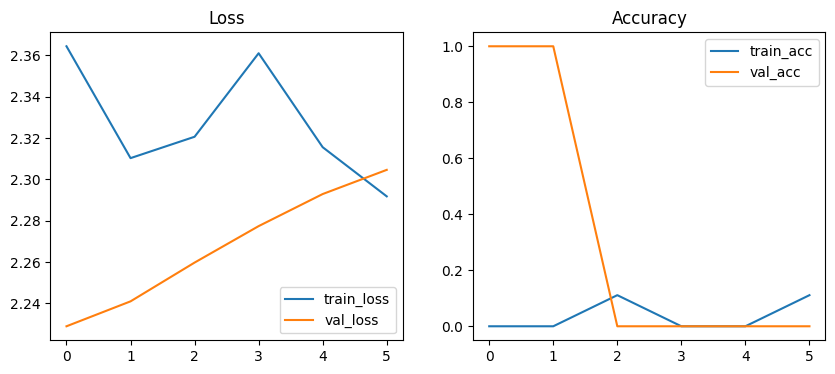

In [22]:
#Plot the learning curves
# Plot loss & accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()


In [23]:
# Show predicted label + probs for validation image
if X_val_f.size:
    probs = model.predict(X_val_f)
    pred_idx = int(probs.argmax(axis=1)[0])
    true_idx = int(y_val_cat.argmax(axis=1)[0])
    print("Predicted index:", pred_idx, "->", label_encoder.classes_[pred_idx])
    print("True index:     ", true_idx, "->", label_encoder.classes_[true_idx])
    # show top 5 probabilities
    top5 = sorted(list(enumerate(probs[0])), key=lambda x:-x[1])[:5]
    print("Top predicted classes (idx,prob):", [(label_encoder.classes_[i], float(round(p,3))) for i,p in top5])
else:
    print("No validation image present.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Predicted index: 4 -> mountain
True index:      4 -> mountain
Top predicted classes (idx,prob): [('mountain', 0.1080000028014183), ('airport', 0.10499999672174454), ('unknown', 0.10499999672174454), ('zoo', 0.10400000214576721), ('water', 0.10199999809265137)]


In [24]:
# Check how model predicts on the training set (apparent memorization)
train_probs = model.predict(X_train_f)
train_preds = train_probs.argmax(axis=1)
train_true = y_train
from collections import Counter
print("Training apparent accuracy:", (train_preds == train_true).mean())
print("Training predicted class counts:", Counter(train_preds))
# Map indices -> class names for top predictions
print({label_encoder.classes_[i]: int(count) for i,count in Counter(train_preds).items()})


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
Training apparent accuracy: 0.0
Training predicted class counts: Counter({np.int64(4): 9})
{'mountain': 9}


3.8 Evaluation of both the models

In [25]:
# imports & helpers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from PIL import Image
from pathlib import Path

def decode_labels(indices, encoder=label_encoder):
    return [encoder.classes_[int(i)] for i in indices]


In [26]:
# Evaluate model on validation set
if X_val_f.size:
    loss, acc = model.evaluate(X_val_f, y_val_cat, verbose=0)
    print(f"Validation loss: {loss:.4f}  |  Validation accuracy: {acc:.4f}")
else:
    print("No validation set to evaluate.")


Validation loss: 2.2289  |  Validation accuracy: 1.0000


In [27]:
# Predictions & confusion matrix (validation)
if X_val_f.size:
    # compute predictions
    probs = model.predict(X_val_f)
    y_pred = np.argmax(probs, axis=1)
    y_true = np.argmax(y_val_cat, axis=1)

    print("Predicted:", label_encoder.classes_[y_pred[0]])
    print("True:", label_encoder.classes_[y_true[0]])

    # Only include the class that appears in validation
    unique_classes = np.unique(y_true)
    target_names_small = label_encoder.classes_[unique_classes]

    print("\nClassification Report (single-sample validation):")
    print(classification_report(y_true, y_pred,
                                labels=unique_classes,
                                target_names=target_names_small,
                                zero_division=0))
else:
    print("No validation set available.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Predicted: mountain
True: mountain

Classification Report (single-sample validation):
              precision    recall  f1-score   support

    mountain       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
Training apparent accuracy: 0.0000
Training predicted class counts:
  mountain       : 9


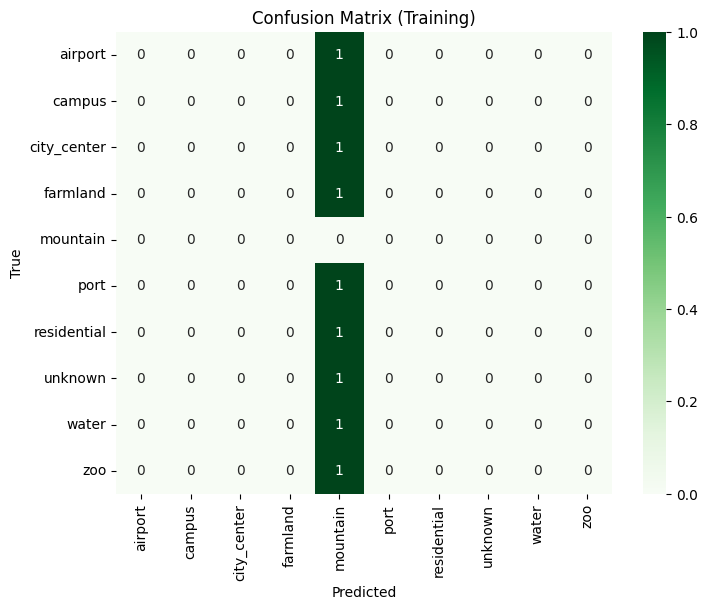

In [28]:
# Evaluate on training set (apparent performance)
train_probs = model.predict(X_train_f)
train_preds = np.argmax(train_probs, axis=1)
train_true = y_train

acc_train = accuracy_score(train_true, train_preds)
print(f"Training apparent accuracy: {acc_train:.4f}")

# show counts of predicted classes for training set
from collections import Counter
cnt = Counter(train_preds)
print("Training predicted class counts:")
for idx, c in cnt.items():
    print(f"  {label_encoder.classes_[idx]:15s}: {c}")

# matrix for training
cm_train = confusion_matrix(train_true, train_preds, labels=range(len(label_encoder.classes_)))
plt.figure(figsize=(8,6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (Training)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


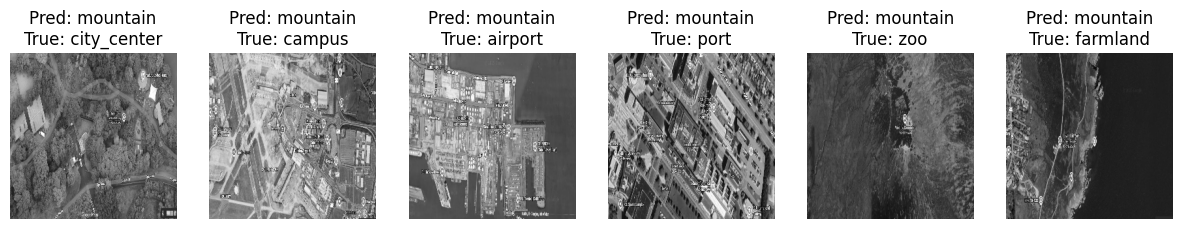

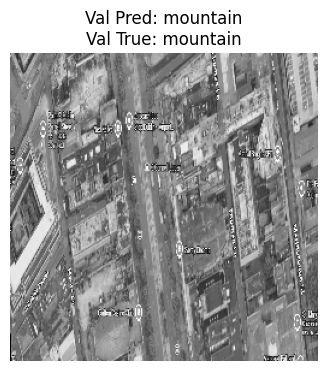

In [29]:
# Visual sample of training + validation images with predictions
def show_image_with_label(img_arr, title):
    plt.imshow((np.clip(img_arr,0,1) * 255).astype('uint8'))
    plt.title(title); plt.axis('off')

# show up to 6 examples from training set
n_show = min(6, len(X_train_f))
plt.figure(figsize=(15, 3*n_show//3 + 1))
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    pred = train_preds[i]
    true = train_true[i]
    show_image_with_label(X_train_f[i], f"Pred: {label_encoder.classes_[pred]}\nTrue: {label_encoder.classes_[true]}")
plt.show()

# show validation image if exists
if X_val_f.size:
    plt.figure(figsize=(4,4))
    show_image_with_label(X_val_f[0], f"Val Pred: {label_encoder.classes_[y_pred[0]]}\nVal True: {label_encoder.classes_[y_true[0]]}")
    plt.show()


Found segmented images: 10


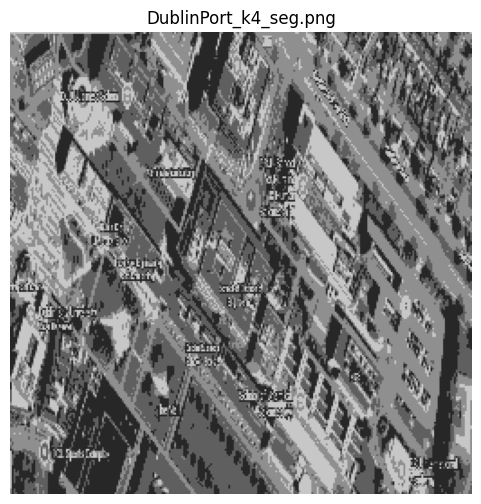

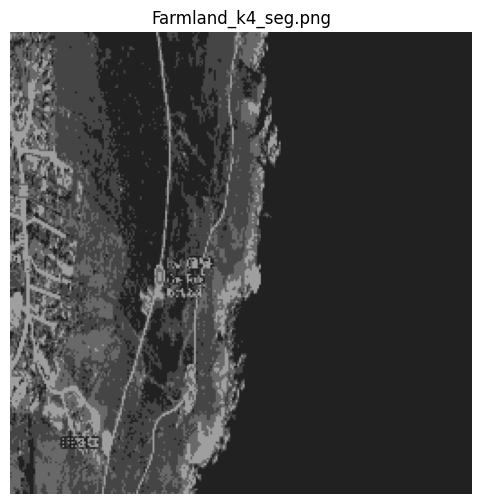

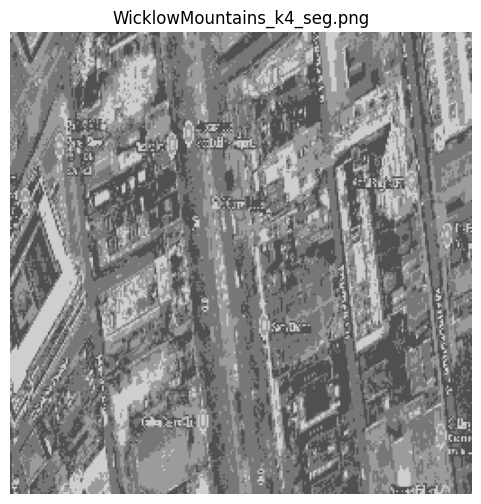

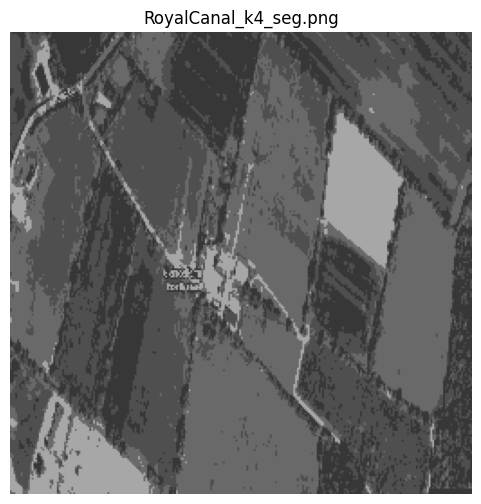

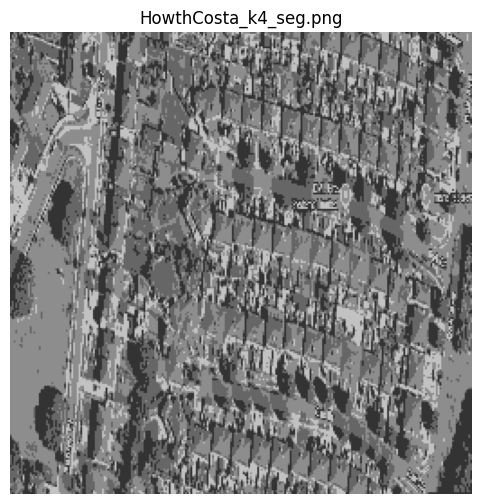

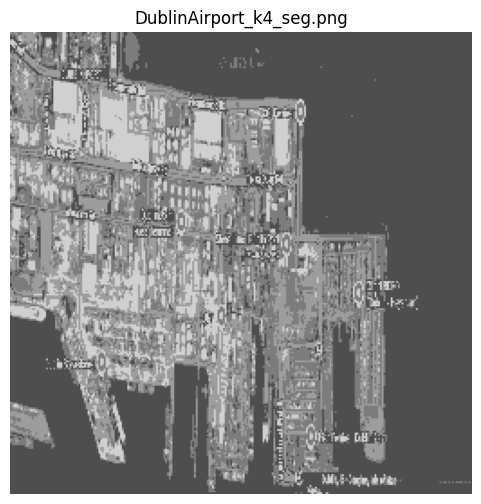

In [30]:
# qualitative check of KMeans outputs saved earlier
cluster_folder = Path("/content/satellite_images/clustered_outputs")  # change if different
if cluster_folder.exists():
    seg_files = list(cluster_folder.glob("*_k4_seg.png"))  # matches the naming used earlier
    if not seg_files:
        seg_files = list(cluster_folder.glob("*.png"))
    print("Found segmented images:", len(seg_files))
    for f in seg_files[:6]:
        img = Image.open(f)
        plt.figure(figsize=(6,6))
        plt.imshow(img); plt.title(f.name); plt.axis('off'); plt.show()
else:
    print("No clustered_outputs folder found; skip qualitative clustering check.")
